In [1]:
import os
import cv2
import numpy as np

import datetime as dt

import tensorflow as tf

import keras
import keras.backend as K
from keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D
from keras import Model
from keras.applications import vgg16
from keras.preprocessing import image as image_utils

import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import file_locations

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 472085900645176925
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15962065537392547503
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16793862270225017709
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23735697408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 324738857029951762
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


## Import Pretrained VGG16

In [2]:
#Take pretrained model
base_model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
base_model.summary()











_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         


## Quick ImageNet Check

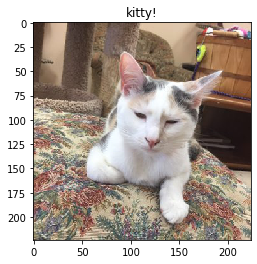

In [3]:
image = image_utils.load_img("./data/kitty.jpg",target_size=(224, 224))
plt.imshow(image)
plt.title('kitty!')
x = image_utils.img_to_array(image)
x = np.expand_dims(x,0)
x = vgg16.preprocess_input(x)

In [5]:
preds = base_model.predict(x)
decoded_preds = vgg16.decode_predictions(preds)
print('Predicted:', decoded_preds)

Predicted: [[('n02124075', 'Egyptian_cat', 0.71381104), ('n02123045', 'tabby', 0.08741847), ('n02123159', 'tiger_cat', 0.037423108), ('n02123597', 'Siamese_cat', 0.035881292), ('n02110185', 'Siberian_husky', 0.035314865)]]


## Model customization

In [29]:
#finetuning model setup (might want to take those 2 fc's.. this is a lot of params)
PRETRAIN_NUM_CLASSES = 101

K.set_learning_phase(0)

base_model = vgg16.VGG16(weights='imagenet', include_top=True, pooling = None, classes=1000, input_shape=(224,224,3))

for layer in base_model.layers[:-2]:
    layer.trainable = False

x = base_model.layers[-2].output
predictions = Dense(PRETRAIN_NUM_CLASSES, name='predictions', activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(x) 
model = Model(inputs=base_model.input, outputs=predictions)

K.set_learning_phase(1)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Pretrain on VPNL Faces

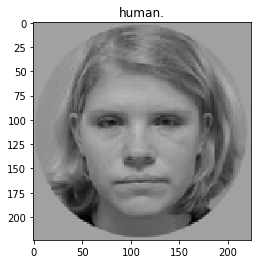

In [30]:
# grab images from database
image = image_utils.load_img(file_locations.PATH_TO_IMDB_GENDER+'../FaceDataCp/000/0_f_0.resample.jpg', target_size=(224,224))
plt.imshow(image)
plt.title("human.")
x = image_utils.img_to_array(image)
x = np.expand_dims(x,0)
x = vgg16.preprocess_input(x)

In [31]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, 
    samplewise_center=False, 
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False, 
    zca_whitening=False, 
    zca_epsilon=1e-06, 
    rotation_range=0, 
    width_shift_range=0.0, 
    height_shift_range=0.0, 
    brightness_range=None, 
    shear_range=0.0, 
    zoom_range=0.0, 
    channel_shift_range=0.0, 
    fill_mode='nearest', 
    cval=0.0, 
    horizontal_flip=False, 
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=vgg16.preprocess_input, 
    data_format=None, 
    validation_split=0.2, 
    dtype=None)

In [32]:
BS = 64

train_it = datagen.flow_from_directory(file_locations.PATH_TO_IMDB_GENDER+"../FaceDataCp/", class_mode = 'categorical', batch_size=BS, target_size=(224,224), shuffle=True, subset='training', seed=1337)
val_it = datagen.flow_from_directory(file_locations.PATH_TO_IMDB_GENDER+"../FaceDataCp/", class_mode='categorical', batch_size=BS, target_size=(224,224), shuffle=False, subset='validation')

Found 1212 images belonging to 101 classes.
Found 303 images belonging to 101 classes.


## Model Retraining

In [38]:
#callbacks to use during trinaing
cpcb = keras.callbacks.ModelCheckpoint(
    file_locations.PATH_TO_CHECKPOINTS+'weights.{}.hdf5'.format(dt.datetime.now().strftime("%Y.%m.%d-%H%M")+"-vpnlfeatures"), 
    monitor='val_categorical_accuracy', verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001, verbose=1)

In [42]:
#choice of optimizer
mx_opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.0005, nesterov=True)
model.compile(optimizer = mx_opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['categorical_accuracy']
             )

In [43]:
#training
history = model.fit_generator(
    train_it,
    steps_per_epoch = train_it.samples // BS,
    validation_data = val_it, 
    validation_steps = val_it.samples // BS,
    epochs = 500,
    callbacks = [ cpcb, reduce_lr ]
)

Epoch 1/500
18/18 [==============================] - 5s 298ms/step - loss: 15.9515 - categorical_accuracy: 0.0113 - val_loss: 15.9271 - val_categorical_accuracy: 0.0126

Epoch 00001: val_categorical_accuracy did not improve from 0.01255
Epoch 2/500
18/18 [==============================] - 4s 238ms/step - loss: 16.0003 - categorical_accuracy: 0.0078 - val_loss: 15.9210 - val_categorical_accuracy: 0.0126

Epoch 00002: val_categorical_accuracy did not improve from 0.01255
Epoch 3/500
18/18 [==============================] - 4s 248ms/step - loss: 15.9398 - categorical_accuracy: 0.0113 - val_loss: 15.9180 - val_categorical_accuracy: 0.0126

Epoch 00003: val_categorical_accuracy did not improve from 0.01255
Epoch 4/500
18/18 [==============================] - 4s 248ms/step - loss: 15.9237 - categorical_accuracy: 0.0122 - val_loss: 15.9301 - val_categorical_accuracy: 0.0117

Epoch 00004: val_categorical_accuracy did not improve from 0.01255
Epoch 5/500
18/18 [==============================] -

18/18 [==============================] - 4s 249ms/step - loss: 16.0449 - categorical_accuracy: 0.0095 - val_loss: 15.9964 - val_categorical_accuracy: 0.0126

Epoch 00068: val_categorical_accuracy did not improve from 0.01255
Epoch 69/500
18/18 [==============================] - 5s 255ms/step - loss: 16.0299 - categorical_accuracy: 0.0105 - val_loss: 16.0099 - val_categorical_accuracy: 0.0117

Epoch 00069: val_categorical_accuracy did not improve from 0.01255
Epoch 70/500
18/18 [==============================] - 5s 255ms/step - loss: 16.0448 - categorical_accuracy: 0.0096 - val_loss: 15.9964 - val_categorical_accuracy: 0.0126

Epoch 00070: val_categorical_accuracy did not improve from 0.01255
Epoch 71/500
18/18 [==============================] - 5s 256ms/step - loss: 16.0579 - categorical_accuracy: 0.0087 - val_loss: 16.1988 - val_categorical_accuracy: 0.0000e+00

Epoch 00071: val_categorical_accuracy did not improve from 0.01255
Epoch 72/500
18/18 [==============================] - 5s 

18/18 [==============================] - 5s 261ms/step - loss: 16.0437 - categorical_accuracy: 0.0096 - val_loss: 16.1986 - val_categorical_accuracy: 0.0000e+00

Epoch 00136: val_categorical_accuracy did not improve from 0.01255
Epoch 137/500
18/18 [==============================] - 5s 257ms/step - loss: 15.9711 - categorical_accuracy: 0.0141 - val_loss: 15.9962 - val_categorical_accuracy: 0.0126

Epoch 00137: val_categorical_accuracy did not improve from 0.01255
Epoch 138/500
18/18 [==============================] - 5s 254ms/step - loss: 16.0586 - categorical_accuracy: 0.0087 - val_loss: 15.9962 - val_categorical_accuracy: 0.0126

Epoch 00138: val_categorical_accuracy did not improve from 0.01255
Epoch 139/500
18/18 [==============================] - 5s 255ms/step - loss: 16.0586 - categorical_accuracy: 0.0087 - val_loss: 16.0097 - val_categorical_accuracy: 0.0117

Epoch 00139: val_categorical_accuracy did not improve from 0.01255
Epoch 140/500
18/18 [==============================] -

18/18 [==============================] - 4s 250ms/step - loss: 16.0305 - categorical_accuracy: 0.0104 - val_loss: 16.0095 - val_categorical_accuracy: 0.0117

Epoch 00204: val_categorical_accuracy did not improve from 0.01255
Epoch 205/500
18/18 [==============================] - 5s 254ms/step - loss: 16.0585 - categorical_accuracy: 0.0087 - val_loss: 15.9961 - val_categorical_accuracy: 0.0126

Epoch 00205: val_categorical_accuracy did not improve from 0.01255
Epoch 206/500
18/18 [==============================] - 5s 254ms/step - loss: 16.1144 - categorical_accuracy: 0.0052 - val_loss: 16.1984 - val_categorical_accuracy: 0.0000e+00

Epoch 00206: val_categorical_accuracy did not improve from 0.01255
Epoch 207/500
18/18 [==============================] - 5s 256ms/step - loss: 15.9867 - categorical_accuracy: 0.0131 - val_loss: 15.9961 - val_categorical_accuracy: 0.0126

Epoch 00207: val_categorical_accuracy did not improve from 0.01255
Epoch 208/500
18/18 [==============================] -

18/18 [==============================] - 4s 247ms/step - loss: 15.9866 - categorical_accuracy: 0.0131 - val_loss: 15.9959 - val_categorical_accuracy: 0.0126

Epoch 00272: val_categorical_accuracy did not improve from 0.01255
Epoch 273/500
18/18 [==============================] - 5s 253ms/step - loss: 16.0443 - categorical_accuracy: 0.0096 - val_loss: 15.9959 - val_categorical_accuracy: 0.0126

Epoch 00273: val_categorical_accuracy did not improve from 0.01255
Epoch 274/500
18/18 [==============================] - 5s 251ms/step - loss: 16.0583 - categorical_accuracy: 0.0087 - val_loss: 16.0094 - val_categorical_accuracy: 0.0117

Epoch 00274: val_categorical_accuracy did not improve from 0.01255
Epoch 275/500
18/18 [==============================] - 4s 247ms/step - loss: 16.0295 - categorical_accuracy: 0.0105 - val_loss: 15.9959 - val_categorical_accuracy: 0.0126

Epoch 00275: val_categorical_accuracy did not improve from 0.01255
Epoch 276/500
18/18 [==============================] - 5s 

18/18 [==============================] - 4s 249ms/step - loss: 16.0154 - categorical_accuracy: 0.0113 - val_loss: 15.9958 - val_categorical_accuracy: 0.0126

Epoch 00340: val_categorical_accuracy did not improve from 0.01255
Epoch 341/500
18/18 [==============================] - 5s 252ms/step - loss: 16.0722 - categorical_accuracy: 0.0078 - val_loss: 16.1982 - val_categorical_accuracy: 0.0000e+00

Epoch 00341: val_categorical_accuracy did not improve from 0.01255
Epoch 342/500
18/18 [==============================] - 5s 251ms/step - loss: 16.0014 - categorical_accuracy: 0.0122 - val_loss: 15.9958 - val_categorical_accuracy: 0.0126

Epoch 00342: val_categorical_accuracy did not improve from 0.01255
Epoch 343/500
18/18 [==============================] - 5s 250ms/step - loss: 16.0862 - categorical_accuracy: 0.0069 - val_loss: 15.9958 - val_categorical_accuracy: 0.0126

Epoch 00343: val_categorical_accuracy did not improve from 0.01255
Epoch 344/500
18/18 [==============================] -

18/18 [==============================] - 5s 255ms/step - loss: 16.0861 - categorical_accuracy: 0.0069 - val_loss: 15.9958 - val_categorical_accuracy: 0.0126

Epoch 00408: val_categorical_accuracy did not improve from 0.01255
Epoch 409/500
18/18 [==============================] - 5s 258ms/step - loss: 16.0293 - categorical_accuracy: 0.0105 - val_loss: 16.0092 - val_categorical_accuracy: 0.0117

Epoch 00409: val_categorical_accuracy did not improve from 0.01255
Epoch 410/500
18/18 [==============================] - 5s 252ms/step - loss: 16.0302 - categorical_accuracy: 0.0104 - val_loss: 15.9957 - val_categorical_accuracy: 0.0126

Epoch 00410: val_categorical_accuracy did not improve from 0.01255
Epoch 411/500
18/18 [==============================] - 5s 255ms/step - loss: 16.0581 - categorical_accuracy: 0.0087 - val_loss: 16.1981 - val_categorical_accuracy: 0.0000e+00

Epoch 00411: val_categorical_accuracy did not improve from 0.01255
Epoch 412/500
18/18 [==============================] -

18/18 [==============================] - 5s 262ms/step - loss: 16.0860 - categorical_accuracy: 0.0069 - val_loss: 16.1980 - val_categorical_accuracy: 0.0000e+00

Epoch 00476: val_categorical_accuracy did not improve from 0.01255
Epoch 477/500
18/18 [==============================] - 5s 255ms/step - loss: 16.0021 - categorical_accuracy: 0.0122 - val_loss: 15.9957 - val_categorical_accuracy: 0.0126

Epoch 00477: val_categorical_accuracy did not improve from 0.01255
Epoch 478/500
18/18 [==============================] - 5s 258ms/step - loss: 16.0852 - categorical_accuracy: 0.0070 - val_loss: 15.9957 - val_categorical_accuracy: 0.0126

Epoch 00478: val_categorical_accuracy did not improve from 0.01255
Epoch 479/500
18/18 [==============================] - 5s 252ms/step - loss: 16.0012 - categorical_accuracy: 0.0122 - val_loss: 16.0091 - val_categorical_accuracy: 0.0117

Epoch 00479: val_categorical_accuracy did not improve from 0.01255
Epoch 480/500
18/18 [==============================] -

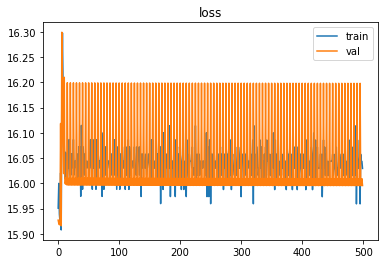

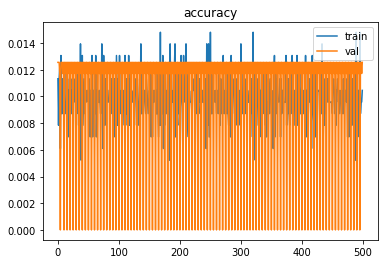

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.legend(["train","val"])
plt.show()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title("accuracy")
plt.legend(["train","val"])
plt.show()

## Update Class Size